# The Battle of the Neighborhoods: Natures of Toronto & NYC Neighborhoods and Prevalence of Covid 19

First, need to import a set of libraries that will be used to conduct various data processing activities throughout the project

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib as mlp

from sklearn import preprocessing
from sklearn.cluster import KMeans # import k-means from clustering stage

import folium # map rendering library
# Import the Folium interactive html file
from IPython.display import HTML

from bs4 import BeautifulSoup # library to parse HTML documents 

print('Libraries imported')

Libraries imported


In order to aggrgate, segment and analyze the data for City of Toronto and New York City (NYC), we need to extract neighborhood data and Covid 19 statistics from various sources for each city.

## 1. Prepare Toronto Neighborhood Data

### Get Toronto Neighborhood data from Wikipedia and clean the data

In [2]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
Torontotable=soup.find('table',{'class':"wikitable"})

# convert Wikipedia table into a Python Datafram
dfT=pd.read_html(str(Torontotable))

# convert list to dataframe
dfT=pd.DataFrame(dfT[0])
print(dfT.shape)
dfT.head()

(180, 3)


Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

##### Data Cleaning

In [3]:
# remove rows with a Borough that is Not assigne
dfT.drop(dfT[dfT['Borough']=='Not assigned'].index, axis=0, inplace=True)

In [4]:
# check the Not assigned values in the Neighbourhood column to recode
dfT_new = dfT[dfT['Neighbourhood']=='Not assigned']
print(dfT_new.shape)
dfT_new.head()

(0, 3)


Empty DataFrame
Columns: [Postal Code, Borough, Neighbourhood]
Index: []

In [5]:
# check for duplicate Postal Codes in order to aggregate at Neighbourhood level
PCodes = np.array(dfT['Postal Code'].value_counts())
PCount = 0
for i in PCodes:
    if i > 1:
        PCount = PCount+1
        
if PCount==0:    
    print('No duplicate postal codes, hence no need to aggregate')
else:
    print('Since there are',PCount,' duplicate postal codes, please aggregate relevant rows')

No duplicate postal codes, hence no need to aggregate


In [7]:
# Reset Index 
dfT=dfT.reset_index(drop=True)

In [8]:
print('Toronto has a total of',len(dfT['Borough'].value_counts()),'boroughs and',dfT.shape[0], 'neighbourhoods.')
dfT.head()

Toronto has a total of 10 boroughs and 103 neighbourhoods.


Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

### Merge Neighborhood data with Geospatial data to get latitudes & longitudes

In [9]:
dfT_PC = pd.read_csv('Geospatial_Coordinates.csv')
dfT_merged = dfT.merge(dfT_PC, how='left', on='Postal Code')
dfT_merged = dfT_merged.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=False)
print(dfT_merged.shape)
dfT_merged.head()

(103, 5)


Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

### Get the Covid 19 statistics in Toronto

In [10]:
# get the covid 19 data from the csv
dfT_Covid = pd.read_csv('COVID19 cases.csv')
print(dfT_Covid.shape)
dfT_Covid.head()

(64725, 18)


_id  Assigned_ID Outbreak Associated       Age Group  \
0  736701            1            Sporadic  50 to 59 Years   
1  736702            2            Sporadic  50 to 59 Years   
2  736703            3            Sporadic  20 to 29 Years   
3  736704            4            Sporadic  60 to 69 Years   
4  736705            5            Sporadic  60 to 69 Years   

      Neighbourhood Name  FSA Source of Infection Classification Episode Date  \
0        Willowdale East  M2N              Travel      CONFIRMED   22/01/2020   
1        Willowdale East  M2N              Travel      CONFIRMED   21/01/2020   
2      Parkwoods-Donalda  M3A              Travel      CONFIRMED   05/02/2020   
3  Church-Yonge Corridor  M4W              Travel      CONFIRMED   16/02/2020   
4  Church-Yonge Corridor  M4W              Travel      CONFIRMED   20/02/2020   

  Reported Date Client Gender   Outcome Currently Hospitalized  \
0    23/01/2020        FEMALE  RESOLVED                     No   
1    23/01/2020          MALE  RESOLVED                     No   
2    21/02/2020        FEMALE  RESOLVED                     No   
3    25/02/2020        FEMALE  RESOLVED                     No   
4    26/02/2020          MALE  RESOLVED                     No   

  Currently in ICU Currently Intubated Ever Hospitalized Ever in ICU  \
0               No                  No                No          No   
1               No                  No               Yes          No   
2               No                  No                No          No   
3               No                  No                No          No   
4               No                  No                No          No   

  Ever Intubated  
0             No  
1             No  
2             No  
3             No  
4             No

In [11]:
dfT_Covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64725 entries, 0 to 64724
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     64725 non-null  int64 
 1   Assigned_ID             64725 non-null  int64 
 2   Outbreak Associated     64725 non-null  object
 3   Age Group               64689 non-null  object
 4   Neighbourhood Name      63422 non-null  object
 5   FSA                     63724 non-null  object
 6   Source of Infection     64725 non-null  object
 7   Classification          64725 non-null  object
 8   Episode Date            64725 non-null  object
 9   Reported Date           64725 non-null  object
 10  Client Gender           64725 non-null  object
 11  Outcome                 64725 non-null  object
 12  Currently Hospitalized  64725 non-null  object
 13  Currently in ICU        64725 non-null  object
 14  Currently Intubated     64725 non-null  object
 15  Ev

In [12]:
dfT_Covid_Filt=dfT_Covid[['FSA','Neighbourhood Name', 'Classification','Age Group', 'Client Gender']]
dfT_Covid_Filt=dfT_Covid_Filt.rename(columns={'FSA':'Postal Code','Neighbourhood Name':'Neighborhood'}, inplace=False)
dfT_Covid_Filt.head()

Postal Code           Neighborhood Classification       Age Group  \
0         M2N        Willowdale East      CONFIRMED  50 to 59 Years   
1         M2N        Willowdale East      CONFIRMED  50 to 59 Years   
2         M3A      Parkwoods-Donalda      CONFIRMED  20 to 29 Years   
3         M4W  Church-Yonge Corridor      CONFIRMED  60 to 69 Years   
4         M4W  Church-Yonge Corridor      CONFIRMED  60 to 69 Years   

  Client Gender  
0        FEMALE  
1          MALE  
2        FEMALE  
3        FEMALE  
4          MALE

In [13]:
# examine the categories to identify potential filters
print(dfT_Covid_Filt.groupby('Classification')['Postal Code'].count())
print(dfT_Covid_Filt.groupby('Age Group')['Postal Code'].count())
print(dfT_Covid_Filt.groupby('Client Gender')['Postal Code'].count())

Classification
CONFIRMED    61556
PROBABLE      2168
Name: Postal Code, dtype: int64
Age Group
19 and younger     7675
20 to 29 Years    12628
30 to 39 Years    10500
40 to 49 Years     8963
50 to 59 Years     9347
60 to 69 Years     6006
70 to 79 Years     3196
80 to 89 Years     3241
90 and older       2145
Name: Postal Code, dtype: int64
Client Gender
FEMALE         32373
MALE           30882
OTHER             14
TRANSGENDER       10
UNKNOWN          445
Name: Postal Code, dtype: int64


In [14]:
# filter only the confirmed cases
dfT_Covid_Filt=dfT_Covid_Filt[dfT_Covid_Filt['Classification']=='CONFIRMED']
dfT_Covid_Filt['Case Count']=1
dfT_Covid_Final=dfT_Covid_Filt.groupby('Postal Code')['Case Count'].count().reset_index()
dfT_Covid_Final=dfT_Covid_Final[['Postal Code','Case Count']]
print('Total number of Covid-19 cases in Toronto as of 6th of January is',dfT_Covid_Final['Case Count'].sum().round(0))
dfT_Covid_Final.head()

Total number of Covid-19 cases in Toronto as of 6th of January is 61556


Postal Code  Case Count
0         M1B        2255
1         M1C         842
2         M1E        1320
3         M1G        1127
4         M1H         709

### Merge Covid & Neighborhood data

In [15]:
dfT_Final = dfT_merged.merge(dfT_Covid_Final, how='left', on='Postal Code')
dfT_Final = dfT_Final.dropna().reset_index(drop=True)
print('Total number of Covid-19 cases in Toronto as of 6th of January is',dfT_Final['Case Count'].sum().round(0))
dfT_Final.head()

Total number of Covid-19 cases in Toronto as of 6th of January is 61556.0


Postal Code           Borough                             Neighborhood  \
0         M3A        North York                                Parkwoods   
1         M4A        North York                         Victoria Village   
2         M5A  Downtown Toronto                Regent Park, Harbourfront   
3         M6A        North York         Lawrence Manor, Lawrence Heights   
4         M9A         Etobicoke  Islington Avenue, Humber Valley Village   

    Latitude  Longitude  Case Count  
0  43.753259 -79.329656       511.0  
1  43.725882 -79.315572       374.0  
2  43.654260 -79.360636       838.0  
3  43.718518 -79.464763       788.0  
4  43.667856 -79.532242       634.0

## 2. Prepare NYC Neighborhood Data

### Get NYC Neighborhood data from the json file and convert to a dataframe with relevant fields

In [16]:
# load json file with NYC neighborhood data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [17]:
# filter and extract neighborhood data into a dataFrame

# extract negiborhood related data from the json file
Neib_data = newyork_data['features']

#define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
dfNYC = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe one row at a time
for data in Neib_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    dfNYC = dfNYC.append({'Borough': borough,
                                'Neighborhood': neighborhood_name,
                                'Latitude': neighborhood_lat,
                                'Longitude': neighborhood_lon}, ignore_index=True)
    
print('New York City has a total of',len(dfNYC['Borough'].value_counts()),'boroughs and',dfNYC.shape[0], 'neighbourhoods.')    
dfNYC.head()

New York City has a total of 5 boroughs and 306 neighbourhoods.


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

### Get the Covid 19 statistics in NYC

In [18]:
# get the latest covid statistcs from the NYC government github data repository
NYC_url = 'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/totals/data-by-modzcta.csv'

dfNYC_Covid = pd.read_csv(NYC_url, error_bad_lines=False)
print(dfNYC_Covid.shape)
dfNYC_Covid.head()

(177, 10)


MODIFIED_ZCTA                        NEIGHBORHOOD_NAME BOROUGH_GROUP  \
0          10001               Chelsea/NoMad/West Chelsea     Manhattan   
1          10002                Chinatown/Lower East Side     Manhattan   
2          10003  East Village/Gramercy/Greenwich Village     Manhattan   
3          10004                       Financial District     Manhattan   
4          10005                       Financial District     Manhattan   

   COVID_CASE_COUNT  COVID_CASE_RATE  POP_DENOMINATOR  COVID_DEATH_COUNT  \
0               786          2846.48         27613.09                 24   
1              2929          3888.60         75322.71                172   
2              1354          2508.44         53977.81                 35   
3               131          4407.63          2972.12                  1   
4               220          2512.21          8757.23                  0   

   COVID_DEATH_RATE  PERCENT_POSITIVE  TOTAL_COVID_TESTS  
0             86.92              5.30              14775  
1            228.35              8.16              35784  
2             64.84              4.00              33980  
3             33.65              4.81               2724  
4              0.00              4.57               4772

In [22]:
# filter only the neighborhood, borough and case count
dfNYC_Covid_Filt = dfNYC_Covid[['NEIGHBORHOOD_NAME','BOROUGH_GROUP','COVID_CASE_COUNT']]
dfNYC_Covid_Filt = dfNYC_Covid_Filt.rename(columns={'NEIGHBORHOOD_NAME':'Neighborhood','BOROUGH_GROUP':'Borough','COVID_CASE_COUNT':'Case Count'})
print(dfNYC_Covid_Filt.shape)
dfNYC_Covid_Filt.head()

(177, 3)


Neighborhood    Borough  Case Count
0               Chelsea/NoMad/West Chelsea  Manhattan         786
1                Chinatown/Lower East Side  Manhattan        2929
2  East Village/Gramercy/Greenwich Village  Manhattan        1354
3                       Financial District  Manhattan         131
4                       Financial District  Manhattan         220

**_Data cleaning and preprosessing_**

Here we see some neighborhoods are concatinated and some are duplicated. First we need to split the neighborhoods which are separated by '/', then assign case counts dividing the number of counts by the number of split, assuming equal distribution of cases in aggregated, but different neighborhoods. Finally, we need to eliminate duplicate neighborhoods by aggregating them to get the cleaned neighborhood wise covid cases dataframe.

In [23]:
# determine number of aggregated words
dfNYC_Covid_Filt['Splits']= dfNYC_Covid_Filt['Neighborhood'].apply(lambda i: len(i.split('/')))

# split neighborhood column to multiple rows
temp = dfNYC_Covid_Filt.assign(Neighborhood=dfNYC_Covid_Filt['Neighborhood'].str.split('/')).explode('Neighborhood').reset_index(drop=True)

# calculate new case count for each neighborhood based on the equality assumption
temp['Case Count']=temp['Case Count']/temp['Splits']

# aggregate neighborhoods to eliminate duplicates and get the cleaned dataframe
dfNYC_Covid_Final = temp.groupby(['Neighborhood','Borough'], as_index=False).agg({'Case Count': 'sum'}).round(0)
print(dfNYC_Covid_Final.shape)
dfNYC_Covid_Final

(226, 3)


Neighborhood        Borough  Case Count
0                           Airport         Queens      2204.0
1                          Allerton          Bronx      2584.0
2                     Alphabet City      Manhattan       602.0
3                          Annadale  Staten Island      2129.0
4                          Arrochar  Staten Island       775.0
5                           Arverne         Queens       824.0
6                   Astoria (North)         Queens      2234.0
7                   Astoria (South)         Queens      2824.0
8                        Auburndale         Queens      1096.0
9                        Bath Beach       Brooklyn      2393.0
10                Battery Park City      Manhattan       314.0
11                        Bay Ridge       Brooklyn      1462.0
12                       Baychester          Bronx      1108.0
13                  Bayside (North)         Queens      1182.0
14                  Bayside (South)         Queens      1026.0
15        Bedford-Stuyvesant (East)       Brooklyn      2754.0
16        Bedford-Stuyvesant (West)       Brooklyn      1287.0
17            Belle Harbor-Neponsit         Queens       702.0
18                        Bellerose         Queens      1928.0
19                          Belmont          Bronx      2409.0
20                      Bensonhurst       Brooklyn      3561.0
21                     Bergen Beach       Brooklyn      1112.0
22                       Bloomfield  Staten Island      3286.0
23                      Boerum Hill       Brooklyn       608.0
24                     Borough Park       Brooklyn      5449.0
25                     Breezy Point         Queens       384.0
26                        Briarwood         Queens      1550.0
27                   Brighton Beach       Brooklyn      2435.0
28                    Broad Channel         Queens       302.0
29                 Brooklyn Heights       Brooklyn       498.0
30                         Bushwick       Brooklyn      2502.0
31                  Cambria Heights         Queens      1011.0
32                         Canarsie       Brooklyn      4391.0
33                  Carroll Gardens       Brooklyn       323.0
34                      Castle Hill          Bronx      1222.0
35           Central Harlem (North)      Manhattan      1993.0
36           Central Harlem (South)      Manhattan      2050.0
37                       Charleston  Staten Island       795.0
38                Charlotte Gardens          Bronx      2192.0
39                          Chelsea      Manhattan      1638.0
40                        Chinatown      Manhattan      1798.0
41                      City Island          Bronx       248.0
42                        Claremont          Bronx      3263.0
43                     Clason Point          Bronx      1222.0
44                     Clinton Hill       Brooklyn      1294.0
45                       Co-op City          Bronx      1222.0
46                      Cobble Hill       Brooklyn       323.0
47                    College Point         Queens      1184.0
48                        Concourse          Bronx      3716.0
49                     Coney Island       Brooklyn       847.0
50                           Corona         Queens      3654.0
51                     Country Club          Bronx      1418.0
52             Crown Heights (East)       Brooklyn      2766.0
53             Crown Heights (West)       Brooklyn      1863.0
54                    Cypress Hills       Brooklyn      4648.0
55                            DUMBO       Brooklyn       498.0
56                 Ditmars Steinway         Queens      1371.0
57           Douglaston-Little Neck         Queens      1300.0
58                Downtown Brooklyn       Brooklyn       498.0
59                    Dyker Heights       Brooklyn      1030.0
60                    East Elmhurst         Queens      1376.0
61            East Flatbush (North)       Brooklyn      1706.0
62            East Flatbush (South)       Brooklyn    

### Merge Covid & Neighborhood data

In [26]:
dfNYC_Final = dfNYC.merge(dfNYC_Covid_Final[['Neighborhood','Case Count']], how='left', on='Neighborhood')
dfNYC_Final = dfNYC_Final.dropna().reset_index(drop=True)
print('Total number of covid-19 cases in New York City as of 6th January 2021 is',dfNYC_Final['Case Count'].sum().round(0))
dfNYC_Final.head()

Total number of covid-19 cases in New York City as of 6th January 2021 is 327721.0


Borough Neighborhood   Latitude  Longitude  Case Count
0   Bronx    Wakefield  40.894705 -73.847201      2364.0
1   Bronx   Co-op City  40.874294 -73.829939      1222.0
2   Bronx    Fieldston  40.895437 -73.905643       433.0
3   Bronx    Riverdale  40.890834 -73.912585      1365.0
4   Bronx  Kingsbridge  40.881687 -73.902818      4000.0

## 3. Use Geopy library and forsquare API to explore the nearby venues in Toronto and NYC

In [150]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'X5UEN3THU0VTW1UQKNW1RGZYKVIRV1TPRNH1AV2R5YAJDCBB'
CLIENT_SECRET = 'DYHAROT252SDZDL2MBA1V4IYIO4IYGD43MM30JWLXQYI0EHI'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Foursquare Credentials and Version have been loaded')

Foursquare Credentials and Version have been loaded


### Use geopy library to get the latitude and longitude values of Toronto. 

In [151]:
address_T = 'Toronto, Ontario'

geolocator_T = Nominatim(user_agent="toronto_explorer")
location_T = geolocator_T.geocode(address_T)
latitude_T = location_T.latitude
longitude_T = location_T.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_T, longitude_T))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Use geopy library to get the latitude and longitude values of NYC. 

In [153]:
address_NYC = 'New York City, NY'

geolocator_NYC = Nominatim(user_agent="NYC_explorer")
location_NYC = geolocator_NYC.geocode(address_NYC)
latitude_NYC = location_NYC.latitude
longitude_NYC = location_NYC.longitude
print('The geograpical coordinate of NYC are {}, {}.'.format(latitude_NYC, longitude_NYC))

The geograpical coordinate of NYC are 40.7127281, -74.0060152.


### Explore the top 100 venues that are in neighbourhood in Toronto & NYC within a radius of 500 meters. 

In [162]:
# common function to extract venues given by dataframe,  latitude and longitude
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [163]:
# get the venues for cleaned Toronto neighborhood data
Toronto_venues = getNearbyVenues(dfT_Final['Neighborhood'],dfT_Final['Latitude'],dfT_Final['Longitude'])
print(Toronto_venues.shape)
Toronto_venues.head(10)

(1659, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0                  Parkwoods              43.753259              -79.329656   
1                  Parkwoods              43.753259              -79.329656   
2           Victoria Village              43.725882              -79.315572   
3           Victoria Village              43.725882              -79.315572   
4           Victoria Village              43.725882              -79.315572   
5           Victoria Village              43.725882              -79.315572   
6           Victoria Village              43.725882              -79.315572   
7  Regent Park, Harbourfront              43.654260              -79.360636   
8  Regent Park, Harbourfront              43.654260              -79.360636   
9  Regent Park, Harbourfront              43.654260              -79.360636   

                                       Venue  Venue Latitude  Venue Longitude  \
0                            Brookbanks Park       43.751976       -79.332140   
1                              Variety Store       43.751974       -79.333114   
2                     Victoria Village Arena       43.723481       -79.315635   
3                                  Portugril       43.725819       -79.312785   
4                                Tim Hortons       43.725517       -79.313103   
5                                   The Frig       43.727051       -79.317418   
6  Eglinton Ave E & Sloane Ave/Bermondsey Rd       43.726086       -79.313620   
7                           Roselle Desserts       43.653447       -79.362017   
8                              Tandem Coffee       43.653559       -79.361809   
9                     Cooper Koo Family YMCA       43.653249       -79.358008   

          Venue Category  
0                   Park  
1      Food & Drink Shop  
2           Hockey Arena  
3  Portuguese Restaurant  
4            Coffee Shop  
5      French Restaurant  
6           Intersection  
7                 Bakery  
8            Coffee Shop  
9    Distribution Center

In [164]:
# get the venues for cleaned NYC neighborhood data
NYC_venues = getNearbyVenues(dfNYC_Final['Neighborhood'],dfNYC_Final['Latitude'],dfNYC_Final['Longitude'])
print(NYC_venues.shape)
NYC_venues.head(10)

(6287, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   
5    Wakefield              40.894705              -73.847201   
6    Wakefield              40.894705              -73.847201   
7    Wakefield              40.894705              -73.847201   
8   Co-op City              40.874294              -73.829939   
9   Co-op City              40.874294              -73.829939   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3         Walgreens       40.896528       -73.844700        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop  
5            Subway       40.890468       -73.849152  Sandwich Place  
6      Central Deli       40.896728       -73.844387   Deli / Bodega  
7   Koss Quick Wash       40.891281       -73.849904      Laundromat  
8    Capri II Pizza       40.876374       -73.829940     Pizza Place  
9          Rite Aid       40.870345       -73.828302        Pharmacy

## Analyze and Cluster Toronto Venues 

### Analyze Neighborhoods 

In [166]:
# One hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column to the nee dataframe
Toronto_onehot['Neighborhood']=Toronto_venues['Neighborhood']

# Get the index of neighborhood column
Neighbour_index=Toronto_onehot.columns.get_indexer(['Neighborhood'])

# Rearrange the columns
fixed_columns= [Toronto_onehot.columns[Neighbour_index[0]]]+list(Toronto_onehot.columns[0:Neighbour_index[0]])+list(Toronto_onehot.columns[Neighbour_index[0]+1:])
Toronto_onehot = Toronto_onehot[fixed_columns]

print(Toronto_onehot.shape)
Toronto_onehot.head()

(1659, 259)


Neighborhood  Accessories Store  Airport  Airport Food Court  \
0         Parkwoods                  0        0                   0   
1         Parkwoods                  0        0                   0   
2  Victoria Village                  0        0                   0   
3  Victoria Village                  0        0                   0   
4  Victoria Village                  0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0                 0                   0      0                0         0   
1                 0                   0      0                0         0   
2                 0                   0      0                0         0   
3                 0                   0      0                0         0   
4                 0                   0      0                0         0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Board Shop  \
0           0                   0          0       0           0   
1           0                   0          0       0           0   
2           0                   0          0       0           0   
3           0                   0          0       0           0   
4           0                   0          0       0           0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0                     0               0   

   Brewery  Bridal Shop  Bubble Tea Shop  Building  Burger Joint  \
0        0            0                0         0             0   
1        0            0                0         0             0   
2        0            0                0         0             0   
3        0            0                0         0             0   
4        0            0                0         0             0   

   Burrito Place  Bus Line  Bus Statio

In [201]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().round(4).reset_index()
print(Toronto_grouped.shape)
Toronto_grouped

(89, 259)


Neighborhood  Accessories Store  \
0                                           Agincourt             0.0000   
1                              Alderwood, Long Branch             0.0000   
2     Bathurst Manor, Wilson Heights, Downsview North             0.0000   
3                                     Bayview Village             0.0000   
4                   Bedford Park, Lawrence Manor East             0.0000   
5                                         Berczy Park             0.0000   
6                         Birch Cliff, Cliffside West             0.0000   
7        Brockton, Parkdale Village, Exhibition Place             0.0000   
8   CN Tower, King and Spadina, Railway Lands, Har...             0.0000   
9                                 Caledonia-Fairbanks             0.0000   
10                                          Cedarbrae             0.0000   
11                                 Central Bay Street             0.0000   
12                                           Christie             0.0000   
13                               Church and Wellesley             0.0000   
14            Clarks Corners, Tam O'Shanter, Sullivan             0.0000   
15    Cliffside, Cliffcrest, Scarborough Village West             0.0000   
16                                         Davisville             0.0000   
17                                   Davisville North             0.0000   
18   Del Ray, Mount Dennis, Keelsdale and Silverthorn             0.0000   
19                                          Don Mills             0.0000   
20  Dorset Park, Wexford Heights, Scarborough Town...             0.0000   
21                                          Downsview             0.0000   
22                       Dufferin, Dovercourt Village             0.0000   
23      East Toronto, Broadview North (Old East York)             0.0000   
24  Eringate, Bloordale Gardens, Old Burnhamthorpe...             0.0000   
25                       Fairview, Henry Farm, Oriole             0.0000   
26    Forest Hill North & West, Forest Hill Road Park             0.0000   
27                           Garden District, Ryerson             0.0000   
28                                          Glencairn             0.0000   
29                    Golden Mile, Clairlea, Oakridge             0.0000   
30                  Guildwood, Morningside, West Hill             0.0000   
31  Harbourfront East, Union Station, Toronto Islands             0.0000   
32                      High Park, The Junction South             0.0000   
33                                  Hillcrest Village             0.0000   
34                                      Humber Summit             0.0000   
35                                   Humberlea, Emery             0.0000   
36                                 Humewood-Cedarvale             0.0000   
37                     India Bazaar, The Beaches West             0.0000   
38        Kennedy Park, Ionview, East Birchmount Park             0.0000   
39          Kensington Market, Chinatown, Grange Park             0.0000   
40  Kingsview Village, St. Phillips, Martin Grove ...             0.0000   
41                   Lawrence Manor, Lawrence Heights             0.0909   
42                                      Lawrence Park             0.0000   
43                                            Leaside             0.0000   
44                           Little Portugal, Trinity             0.0000   
45                                     Malvern, Rouge             0.0000   
46  Milliken, Agincourt North, Steeles East, L'Amo...             0.0000   
47  Mimico NW, The Queensway West, South of Bloor,...             0.0000   
48                        Moore Park, Summerhill East             0.0000   
49       New Toronto, Mimico South, Humber Bay Shores             0.0000   
50           North Park, Maple Leaf Park, Upwood Park             0.0000   
51                  North Toronto West, Lawrence Park             0.0000   
52           

In [170]:
# sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [175]:
# new dataframe and display the top 10 venues for each neighborhood based on frequency
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)   
neighborhoods_venues_sorted.head(10)

Neighborhood 1st Most Common Venue  \
0                                          Agincourt                Lounge   
1                             Alderwood, Long Branch           Pizza Place   
2    Bathurst Manor, Wilson Heights, Downsview North           Coffee Shop   
3                                    Bayview Village                  Café   
4                  Bedford Park, Lawrence Manor East           Coffee Shop   
5                                        Berczy Park           Coffee Shop   
6                        Birch Cliff, Cliffside West       College Stadium   
7       Brockton, Parkdale Village, Exhibition Place                  Café   
8  CN Tower, King and Spadina, Railway Lands, Har...       Airport Service   
9                                Caledonia-Fairbanks                  Park   

       2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0  Latin American Restaurant        Breakfast Spot     Chinese Restaurant   
1                        Gym        Sandwich Place            Coffee Shop   
2                       Bank    Frozen Yogurt Shop            Bridal Shop   
3                       Bank   Japanese Restaurant     Chinese Restaurant   
4         Italian Restaurant        Sandwich Place        Thai Restaurant   
5               Cocktail Bar        Farmers Market             Restaurant   
6      General Entertainment          Skating Rink                   Café   
7             Breakfast Spot           Coffee Shop  Performing Arts Venue   
8             Airport Lounge      Airport Terminal        Harbor / Marina   
9              Women's Store                  Pool             Donut Shop   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0             Drugstore   Distribution Center               Dog Run   
1          Skating Rink                   Pub               Dog Run   
2        Sandwich Place                 Diner            Restaurant   
3            Donut Shop   Distribution Center               Dog Run   
4         Grocery Store     Indian Restaurant             Juice Bar   
5                Bakery              Beer Bar           Cheese Shop   
6    Dim Sum Restaurant                 Diner        Discount Store   
7                Bakery               Stadium         Burrito Place   
8              Boutique           Coffee Shop                 Plane   
9                 Diner        Discount Store   Distribution Center   

  8th Most Common Venue    9th Most Common Venue       10th Most Common Venue  
0      Doner Restaurant               Donut Shop                  Yoga Studio  
1                 Diner           Discount Store          Distribution Center  
2          Intersection              Supermarket             Sushi Restaurant  
3      Doner Restaurant                Drugstore                        Diner  
4          Liquor Store  Comfort Food Restaurant                     Pharmacy  
5    Seafood Restaurant           Clothing Store          Sporting Goods Shop  
6   Distribution Center                  Dog Run                   Donut Shop  
7            Restaurant             Climbing Gym                    Pet Store  
8      Sculpture Garden      Rental Car Location                Boat or Ferry  
9               Dog Run         Doner Restaurant  Eastern European Restaurant

### Cluster Neighborhoods 

In [176]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 1])

In [177]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head(10)

Cluster Labels                                       Neighborhood  \
0               3                                          Agincourt   
1               3                             Alderwood, Long Branch   
2               3    Bathurst Manor, Wilson Heights, Downsview North   
3               3                                    Bayview Village   
4               3                  Bedford Park, Lawrence Manor East   
5               3                                        Berczy Park   
6               3                        Birch Cliff, Cliffside West   
7               3       Brockton, Parkdale Village, Exhibition Place   
8               3  CN Tower, King and Spadina, Railway Lands, Har...   
9               1                                Caledonia-Fairbanks   

  1st Most Common Venue      2nd Most Common Venue 3rd Most Common Venue  \
0                Lounge  Latin American Restaurant        Breakfast Spot   
1           Pizza Place                        Gym        Sandwich Place   
2           Coffee Shop                       Bank    Frozen Yogurt Shop   
3                  Café                       Bank   Japanese Restaurant   
4           Coffee Shop         Italian Restaurant        Sandwich Place   
5           Coffee Shop               Cocktail Bar        Farmers Market   
6       College Stadium      General Entertainment          Skating Rink   
7                  Café             Breakfast Spot           Coffee Shop   
8       Airport Service             Airport Lounge      Airport Terminal   
9                  Park              Women's Store                  Pool   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0     Chinese Restaurant             Drugstore   Distribution Center   
1            Coffee Shop          Skating Rink                   Pub   
2            Bridal Shop        Sandwich Place                 Diner   
3     Chinese Restaurant            Donut Shop   Distribution Center   
4        Thai Restaurant         Grocery Store     Indian Restaurant   
5             Restaurant                Bakery              Beer Bar   
6                   Café    Dim Sum Restaurant                 Diner   
7  Performing Arts Venue                Bakery               Stadium   
8        Harbor / Marina              Boutique           Coffee Shop   
9             Donut Shop                 Diner        Discount Store   

  7th Most Common Venue 8th Most Common Venue    9th Most Common Venue  \
0               Dog Run      Doner Restaurant               Donut Shop   
1               Dog Run                 Diner           Discount Store   
2            Restaurant          Intersection              Supermarket   
3               Dog Run      Doner Restaurant                Drugstore   
4             Juice Bar          Liquor Store  Comfort Food Restaurant   
5           Cheese Shop    Seafood Restaurant           Clothing Store   
6        Discount Store   Distribution Center                  Dog Run   
7         Burrito Place            Restaurant             Climbing Gym   
8                 Plane      Sculpture Garden      Rental Car Location   
9   Distribution Center               Dog Run         Doner Restaurant   

        10th Most Common Venue  
0                  Yoga Studio  
1          Distribution Center  
2             Sushi Restaurant  
3                        Diner  
4                     Pharmacy  
5          Sporting Goods Shop  
6                   Donut Shop  
7                    Pet Store  
8                Boat or Ferry  
9  Eastern European Restaurant

In [194]:
# merge with  cleaned Toronto dataframe to add latitude/longitude for each neighborhood
Toronto_clustered = dfT_Final
Toronto_clustered = Toronto_clustered.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Toronto_clustered = Toronto_clustered.dropna().reset_index(drop=True)
Toronto_clustered['Cluster Labels'] = Toronto_clustered['Cluster Labels'].astype(int)
Toronto_clustered.head()

Postal Code           Borough                      Neighborhood   Latitude  \
0         M3A        North York                         Parkwoods  43.753259   
1         M4A        North York                  Victoria Village  43.725882   
2         M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3         M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4         M1B       Scarborough                    Malvern, Rouge  43.806686   

   Longitude  Case Count  Cluster Labels  1st Most Common Venue  \
0 -79.329656       511.0               0                   Park   
1 -79.315572       374.0               3  Portuguese Restaurant   
2 -79.360636       838.0               3            Coffee Shop   
3 -79.464763       788.0               3         Clothing Store   
4 -79.194353      2255.0               3   Fast Food Restaurant   

  2nd Most Common Venue 3rd Most Common Venue   4th Most Common Venue  \
0     Food & Drink Shop           Yoga Studio      Dim Sum Restaurant   
1     French Restaurant           Coffee Shop            Hockey Arena   
2                  Park                Bakery                    Café   
3     Accessories Store              Boutique  Furniture / Home Store   
4  Colombian Restaurant        Farmers Market      Falafel Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0           Event Space  Ethiopian Restaurant           Escape Room   
1          Intersection      Doner Restaurant                 Diner   
2        Breakfast Spot                   Pub               Theater   
3           Event Space           Coffee Shop         Women's Store   
4           Event Space  Ethiopian Restaurant           Escape Room   

   8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
0      Electronics Store  Eastern European Restaurant              Drugstore  
1         Discount Store          Distribution Center                Dog Run  
2            Yoga Studio                   Shoe Store                Brewery  
3  Vietnamese Restaurant          Distribution Center                  Field  
4      Electronics Store  Eastern European Restaurant              Drugstore

In [195]:
# see the distribution of clusters
Toronto_clustered.groupby(['Cluster Labels'])['Borough'].count()

Cluster Labels
0    10
1     6
2     1
3    74
4     2
Name: Borough, dtype: int64

### Visualize the clusters 

In [193]:
# create map
T_map_clusters = folium.Map(location=[latitude_T, longitude_T], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_clustered['Latitude'], Toronto_clustered['Longitude'], Toronto_clustered['Neighborhood'], Toronto_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(T_map_clusters)
       
T_map_clusters

## Analyze and Cluster NYC Venues 

### Analyze Neighborhoods 

In [198]:
# One hot encoding
NYC_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column to the nee dataframe
NYC_onehot['Neighborhood']=NYC_venues['Neighborhood']

# Get the index of neighborhood column
Neighbour_index_NYC=NYC_onehot.columns.get_indexer(['Neighborhood'])

# Rearrange the columns
fixed_columns_NYC= [NYC_onehot.columns[Neighbour_index_NYC[0]]]+list(NYC_onehot.columns[0:Neighbour_index_NYC[0]])+list(NYC_onehot.columns[Neighbour_index_NYC[0]+1:])
NYC_onehot = NYC_onehot[fixed_columns_NYC]

print(NYC_onehot.shape)
NYC_onehot.head()

(6287, 383)


Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield                  0               0                  0   
1    Wakefield                  0               0                  0   
2    Wakefield                  0               0                  0   
3    Wakefield                  0               0                  0   
4    Wakefield                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                   0                    0             0       0   
1                   0                    0             0       0   
2                   0                    0             0       0   
3                   0                    0             0       0   
4                   0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Workshop  Automotive Shop  BBQ Joint  Bagel Shop  Baggage Locker  \
0              0                0          0           0               0   
1              0                0          0           0               0   
2              0                0          0           0               0   
3              0                0          0           0               0   
4              0                0          0           0               0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     0    0               0                 0                 0   
2       0     0    0               0                 0                 0   
3       0     0    0               0                 0                 0   
4       0     0    0               0                 0                 0   

   Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0           0      0                0         0            0           0   
1           0      0                0         0            0           0   
2           0      0                0         0            0           0   
3           0      0                0         0            0           0   
4           0      0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0              0                         0          0       0           0   
1              0                         0          0       0           0   
2              0                         0          0       0           0   
3              0                         0          0       0           0   
4              0                         0          0       0           0   

   Boat o

In [204]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
NYC_grouped = NYC_onehot.groupby('Neighborhood').mean().round(4).reset_index()
print(NYC_grouped.shape)
NYC_grouped

(176, 383)


Neighborhood  Accessories Store  Adult Boutique  \
0                     Allerton             0.0000          0.0000   
1                     Annadale             0.0000          0.0000   
2                     Arrochar             0.0000          0.0000   
3                      Arverne             0.0000          0.0000   
4                   Auburndale             0.0000          0.0000   
5                   Bath Beach             0.0000          0.0000   
6            Battery Park City             0.0000          0.0000   
7                    Bay Ridge             0.0000          0.0000   
8                   Baychester             0.0000          0.0000   
9                    Bellerose             0.0000          0.0000   
10                     Belmont             0.0000          0.0000   
11                 Bensonhurst             0.0000          0.0000   
12                Bergen Beach             0.0000          0.0000   
13                  Bloomfield             0.0000          0.0000   
14                 Boerum Hill             0.0000          0.0000   
15                Borough Park             0.0000          0.0000   
16                Breezy Point             0.0000          0.0000   
17                   Briarwood             0.0000          0.0000   
18              Brighton Beach             0.0000          0.0000   
19               Broad Channel             0.0000          0.0000   
20            Brooklyn Heights             0.0000          0.0000   
21                    Bushwick             0.0000          0.0000   
22             Cambria Heights             0.0000          0.0000   
23                    Canarsie             0.0000          0.0000   
24             Carroll Gardens             0.0000          0.0000   
25                 Castle Hill             0.0000          0.0000   
26                  Charleston             0.0000          0.0000   
27                     Chelsea             0.0000          0.0000   
28                   Chinatown             0.0000          0.0000   
29                 City Island             0.0000          0.0000   
30                Clason Point             0.0000          0.0000   
31                Clinton Hill             0.0000          0.0000   
32                  Co-op City             0.0000          0.0000   
33                 Cobble Hill             0.0000          0.0000   
34               College Point             0.0000          0.0000   
35                   Concourse             0.0000          0.0000   
36                Coney Island             0.0000          0.0000   
37                      Corona             0.0000          0.0000   
38                Country Club             0.0000          0.0000   
39               Cypress Hills             0.0000          0.0000   
40               Dyker Heights             0.0000          0.0000   
41               East Elmhurst             0.0000          0.0000   
42                 East Harlem             0.0000          0.0000   
43               East New York             0.0000          0.0000   
44                East Village             0.0000          0.0000   
45           East Williamsburg             0.0000          0.0000   
46                    Edenwald             0.0000          0.0000   
47                    Edgemere             0.0000          0.0000   
48                    Elm Park             0.0000          0.0000   
49                    Elmhurst             0.0000          0.0000   
50                Far Rockaway             0.0000          0.0000   
51                   Fieldston             0.0000          0.0000   
52          Financial District             0.0000          0.0000   
53                    Flatbush             0.0000          0.0000   
54                    Flatiron             0.0000          0.0000   
55                   Flatlands             0.0000          0.0000   
56                    Flushing             0.0000          0.0000   
57              

In [205]:
# create a new dataframe
neighborhoods_venues_sorted_NYC = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_NYC['Neighborhood'] = NYC_grouped['Neighborhood']

for ind in np.arange(NYC_grouped.shape[0]):
    neighborhoods_venues_sorted_NYC.iloc[ind, 1:] = return_most_common_venues(NYC_grouped.iloc[ind, :], num_top_venues)   
neighborhoods_venues_sorted_NYC.head(10)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0           Allerton         Deli / Bodega           Pizza Place   
1           Annadale                  Park                  Food   
2           Arrochar              Bus Stop    Italian Restaurant   
3            Arverne             Surf Spot        Sandwich Place   
4         Auburndale    Italian Restaurant        Gymnastics Gym   
5         Bath Beach           Pizza Place              Pharmacy   
6  Battery Park City           Coffee Shop                 Hotel   
7          Bay Ridge           Pizza Place                   Spa   
8         Baychester            Donut Shop   Fried Chicken Joint   
9          Bellerose         Deli / Bodega           Pizza Place   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Supermarket   Fried Chicken Joint              Pharmacy   
1              Pharmacy                 Diner      Sushi Restaurant   
2         Deli / Bodega           Pizza Place            Food Truck   
3         Metro Station            Board Shop              Bus Stop   
4     Mobile Phone Shop        Mattress Store  Fast Food Restaurant   
5           Gas Station   Peruvian Restaurant            Donut Shop   
6                  Park        Clothing Store                   Gym   
7    Italian Restaurant            Bagel Shop   American Restaurant   
8     Food & Drink Shop    Spanish Restaurant           Bus Station   
9    Chinese Restaurant           Flower Shop    Italian Restaurant   

       6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0             Breakfast Spot                    Spa           Gas Station   
1                 Restaurant                 Bakery           Pizza Place   
2  Middle Eastern Restaurant  Outdoors & Recreation    Athletics & Sports   
3                      Beach              BBQ Joint           Coffee Shop   
4           Toy / Game Store       Sushi Restaurant             Pet Store   
5            Bubble Tea Shop     Italian Restaurant    Chinese Restaurant   
6              Memorial Site             Food Court          Burger Joint   
7                        Bar       Greek Restaurant            Hookah Bar   
8                Supermarket     Mexican Restaurant  Fast Food Restaurant   
9          Mobile Phone Shop                  Diner    Seafood Restaurant   

      9th Most Common Venue 10th Most Common Venue  
0      Fast Food Restaurant    Martial Arts School  
1       American Restaurant           Dance Studio  
2  Mediterranean Restaurant            Supermarket  
3                Donut Shop                   Café  
4                  Pharmacy           Noodle House  
5      Fast Food Restaurant   Cantonese Restaurant  
6             Shopping Mall                  Plaza  
7            Sandwich Place     Chinese Restaurant  
8             Boat or Ferry            Men's Store  
9              Liquor Store                   Bank

### Cluster Neighborhoods

In [206]:
# set number of clusters
kclusters = 5

NYC_grouped_clustering = NYC_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_NYC = KMeans(n_clusters=kclusters, random_state=0).fit(NYC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_NYC.labels_[0:10]

array([4, 1, 1, 1, 1, 1, 1, 1, 1, 4])

In [207]:
# add clustering labels
neighborhoods_venues_sorted_NYC.insert(0, 'Cluster Labels', kmeans_NYC.labels_)
neighborhoods_venues_sorted_NYC.head(10)

Cluster Labels       Neighborhood 1st Most Common Venue  \
0               4           Allerton         Deli / Bodega   
1               1           Annadale                  Park   
2               1           Arrochar              Bus Stop   
3               1            Arverne             Surf Spot   
4               1         Auburndale    Italian Restaurant   
5               1         Bath Beach           Pizza Place   
6               1  Battery Park City           Coffee Shop   
7               1          Bay Ridge           Pizza Place   
8               1         Baychester            Donut Shop   
9               4          Bellerose         Deli / Bodega   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Pizza Place           Supermarket   Fried Chicken Joint   
1                  Food              Pharmacy                 Diner   
2    Italian Restaurant         Deli / Bodega           Pizza Place   
3        Sandwich Place         Metro Station            Board Shop   
4        Gymnastics Gym     Mobile Phone Shop        Mattress Store   
5              Pharmacy           Gas Station   Peruvian Restaurant   
6                 Hotel                  Park        Clothing Store   
7                   Spa    Italian Restaurant            Bagel Shop   
8   Fried Chicken Joint     Food & Drink Shop    Spanish Restaurant   
9           Pizza Place    Chinese Restaurant           Flower Shop   

  5th Most Common Venue      6th Most Common Venue  7th Most Common Venue  \
0              Pharmacy             Breakfast Spot                    Spa   
1      Sushi Restaurant                 Restaurant                 Bakery   
2            Food Truck  Middle Eastern Restaurant  Outdoors & Recreation   
3              Bus Stop                      Beach              BBQ Joint   
4  Fast Food Restaurant           Toy / Game Store       Sushi Restaurant   
5            Donut Shop            Bubble Tea Shop     Italian Restaurant   
6                   Gym              Memorial Site             Food Court   
7   American Restaurant                        Bar       Greek Restaurant   
8           Bus Station                Supermarket     Mexican Restaurant   
9    Italian Restaurant          Mobile Phone Shop                  Diner   

  8th Most Common Venue     9th Most Common Venue 10th Most Common Venue  
0           Gas Station      Fast Food Restaurant    Martial Arts School  
1           Pizza Place       American Restaurant           Dance Studio  
2    Athletics & Sports  Mediterranean Restaurant            Supermarket  
3           Coffee Shop                Donut Shop                   Café  
4             Pet Store                  Pharmacy           Noodle House  
5    Chinese Restaurant      Fast Food Restaurant   Cantonese Restaurant  
6          Burger Joint             Shopping Mall                  Plaza  
7            Hookah Bar            Sandwich Place     Chinese Restaurant  
8  Fast Food Restaurant             Boat or Ferry            Men's Store  
9    Seafood Restaurant              Liquor Store                   Bank

In [208]:
# merge with  cleaned NYC dataframe to add latitude/longitude for each neighborhood
NYC_clustered = dfNYC_Final
NYC_clustered = NYC_clustered.join(neighborhoods_venues_sorted_NYC.set_index('Neighborhood'), on='Neighborhood')
NYC_clustered = NYC_clustered.dropna().reset_index(drop=True)
NYC_clustered['Cluster Labels'] = NYC_clustered['Cluster Labels'].astype(int)
NYC_clustered.head()

Borough Neighborhood   Latitude  Longitude  Case Count  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201      2294.0               4   
1   Bronx   Co-op City  40.874294 -73.829939      1197.0               0   
2   Bronx    Fieldston  40.895437 -73.905643       416.0               0   
3   Bronx    Riverdale  40.890834 -73.912585      1314.0               0   
4   Bronx  Kingsbridge  40.881687 -73.902818      3859.0               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy        Sandwich Place        Ice Cream Shop   
1           Bus Station                  Park            Restaurant   
2                 River                 Plaza           Bus Station   
3                  Park           Bus Station                  Bank   
4           Pizza Place                   Bar        Sandwich Place   

  4th Most Common Venue 5th Most Common Venue      6th Most Common Venue  \
0         Deli / Bodega          Dessert Shop                 Donut Shop   
1         Grocery Store            Bagel Shop                   Pharmacy   
2           Yoga Studio   Filipino Restaurant         English Restaurant   
3                 Plaza                   Gym       Medical Supply Store   
4         Deli / Bodega    Mexican Restaurant  Latin American Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Laundromat           Yoga Studio  Ethiopian Restaurant   
1  Fast Food Restaurant        Discount Store           Pizza Place   
2  Ethiopian Restaurant         Event Service           Event Space   
3          Home Service            Playground        Baseball Field   
4    Chinese Restaurant    Spanish Restaurant              Pharmacy   

  10th Most Common Venue  
0          Event Service  
1         Baseball Field  
2                Exhibit  
3            Flower Shop  
4                 Bakery

In [209]:
# see the distribution of clusters
NYC_clustered.groupby(['Cluster Labels'])['Borough'].count()

Cluster Labels
0     20
1    124
2      1
3      1
4     35
Name: Borough, dtype: int64

### Visualize the Clusters

In [210]:
# create map
NYC_map_clusters = folium.Map(location=[latitude_NYC, longitude_NYC], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYC_clustered['Latitude'], NYC_clustered['Longitude'], NYC_clustered['Neighborhood'], NYC_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(NYC_map_clusters)
       
NYC_map_clusters

## Examin Clusters 

### Toronto Clusters 

**Cluster 1**

In [221]:
Toronto_clustered.loc[Toronto_clustered['Cluster Labels'] == 0, Toronto_clustered.columns[[1]+[2]+[5]+ list(range(7, Toronto_clustered.shape[1]))]]

Borough                                       Neighborhood  \
0        North York                                          Parkwoods   
11        East York                                   Woodbine Heights   
13             York                                 Humewood-Cedarvale   
44       North York           North Park, Maple Leaf Park, Upwood Park   
56  Central Toronto                                      Lawrence Park   
62  Central Toronto                                   Davisville North   
63  Central Toronto    Forest Hill North & West, Forest Hill Road Park   
71        Etobicoke  Kingsview Village, St. Phillips, Martin Grove ...   
77  Central Toronto                        Moore Park, Summerhill East   
79      Scarborough  Milliken, Agincourt North, Steeles East, L'Amo...   

    Case Count 1st Most Common Venue 2nd Most Common Venue  \
0        511.0                  Park     Food & Drink Shop   
11       626.0                   Spa            Beer Store   
13       310.0                 Field                  Park   
44       877.0                Bakery                  Park   
56       150.0                  Park              Bus Line   
62       254.0                  Park                 Hotel   
63       166.0                  Park              Bus Line   
71      1034.0     Mobile Phone Shop                  Park   
77        82.0          Tennis Court                  Park   
79      1041.0          Intersection                  Park   

         3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Yoga Studio    Dim Sum Restaurant           Event Space   
11                 Curling Ice          Dance Studio          Skating Rink   
13                Hockey Arena                 Trail            Donut Shop   
44  Construction & Landscaping           Yoga Studio             Drugstore   
56                 Swim School    Dim Sum Restaurant           Yoga Studio   
62              Breakfast Spot     Food & Drink Shop        Sandwich Place   
63            Sushi Restaurant                 Trail         Jewelry Store   
71              Sandwich Place              Bus Line      Doner Restaurant   
77                       Trail      Doner Restaurant    Dim Sum Restaurant   
79                  Playground            Donut Shop                 Diner   

   6th Most Common Venue   7th Most Common Venue       8th Most Common Venue  \
0   Ethiopian Restaurant             Escape Room           Electronics Store   
11                  Park  Gluten-free Restaurant                   Gift Shop   
13                 Diner          Discount Store         Distribution Center   
44   Distribution Center                 Dog Run            Doner Restaurant   
56      Doner Restaurant          Discount Store         Distribution Center   
62      Department Store             Pizza Place  Construction & Landscaping   
63      Doner Restaurant          Discount Store         Distribution Center   
71                 Diner          Discount Store         Distribution Center   
77                 Diner          Discount Store         Distribution Center   
79        Discount Store     Distribution Center                     Dog Run   

          9th Most Common Venue 10th Most Common Venue  
0   Eastern European Restaurant              Drugstore  
11                  Escape Room           Gourmet Shop  
13                      Dog Run       Doner Restaurant  
44                   Donut Shop      Electronics Store  
56                      Dog Run              Drugstore  
62            Convenience Store            Escape Room  
63                      Dog Run             Donut Shop  
71                      Dog Run            Yoga Studio  
77                      Dog Run             Donut Shop  
79             Doner Restaurant            Yoga Studio

**Cluster 2**

In [269]:
Toronto_clustered.loc[Toronto_clustered['Cluster Labels'] == 1, Toronto_clustered.columns[[1]+[2]+[5]+ list(range(7, Toronto_clustered.shape[1]))]]

Borough                                   Neighborhood  \
18              York                            Caledonia-Fairbanks   
32         East York  East Toronto, Broadview North (Old East York)   
47        North York                        Willowdale, Newtonbrook   
61        North York                                York Mills West   
85  Downtown Toronto                                       Rosedale   
89         Etobicoke  The Kingsway, Montgomery Road, Old Mill North   

    Case Count 1st Most Common Venue 2nd Most Common Venue  \
18       930.0                  Park         Women's Store   
32       409.0                  Park           Coffee Shop   
47       607.0                  Park           Yoga Studio   
61        67.0                  Park     Convenience Store   
85       120.0                  Park            Playground   
89       109.0                  Park                 River   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
18                  Pool            Donut Shop                 Diner   
32     Convenience Store           Yoga Studio             Drugstore   
47    Dim Sum Restaurant    Falafel Restaurant           Event Space   
61           Yoga Studio             Drugstore        Discount Store   
85                 Trail           Yoga Studio      Doner Restaurant   
89                  Pool           Yoga Studio      Doner Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
18        Discount Store   Distribution Center               Dog Run   
32        Discount Store   Distribution Center               Dog Run   
47  Ethiopian Restaurant           Escape Room     Electronics Store   
61   Distribution Center               Dog Run      Doner Restaurant   
85    Dim Sum Restaurant                 Diner        Discount Store   
89    Dim Sum Restaurant                 Diner        Discount Store   

          9th Most Common Venue       10th Most Common Venue  
18             Doner Restaurant  Eastern European Restaurant  
32             Doner Restaurant                   Donut Shop  
47  Eastern European Restaurant                    Drugstore  
61                   Donut Shop            Electronics Store  
85          Distribution Center                      Dog Run  
89          Distribution Center                      Dog Run

**Cluster 3**

In [270]:
Toronto_clustered.loc[Toronto_clustered['Cluster Labels'] == 2, Toronto_clustered.columns[[1]+[2]+[5]+ list(range(7, Toronto_clustered.shape[1]))]]

Borough              Neighborhood  Case Count 1st Most Common Venue  \
41  North York  York Mills, Silver Hills        93.0   Martial Arts School   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
41           Yoga Studio  Colombian Restaurant    Falafel Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
41           Event Space  Ethiopian Restaurant           Escape Room   

   8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
41     Electronics Store  Eastern European Restaurant              Drugstore

**Cluster 4**

In [271]:
Toronto_clustered.loc[Toronto_clustered['Cluster Labels'] == 3, Toronto_clustered.columns[[1]+[2]+[5]+ list(range(7, Toronto_clustered.shape[1]))]]

Borough                                       Neighborhood  \
1         North York                                   Victoria Village   
2   Downtown Toronto                          Regent Park, Harbourfront   
3         North York                   Lawrence Manor, Lawrence Heights   
4        Scarborough                                     Malvern, Rouge   
5         North York                                          Don Mills   
6          East York                    Parkview Hill, Woodbine Gardens   
7   Downtown Toronto                           Garden District, Ryerson   
8         North York                                          Glencairn   
9        Scarborough             Rouge Hill, Port Union, Highland Creek   
10        North York                                          Don Mills   
12  Downtown Toronto                                     St. James Town   
14         Etobicoke  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
15       Scarborough                  Guildwood, Morningside, West Hill   
16      East Toronto                                        The Beaches   
17  Downtown Toronto                                        Berczy Park   
19       Scarborough                                             Woburn   
20         East York                                            Leaside   
21  Downtown Toronto                                 Central Bay Street   
22  Downtown Toronto                                           Christie   
23       Scarborough                                          Cedarbrae   
24        North York                                  Hillcrest Village   
25        North York    Bathurst Manor, Wilson Heights, Downsview North   
26         East York                                   Thorncliffe Park   
27  Downtown Toronto                           Richmond, Adelaide, King   
28      West Toronto                       Dufferin, Dovercourt Village   
29       Scarborough                                Scarborough Village   
30        North York                       Fairview, Henry Farm, Oriole   
31        North York                    Northwood Park, York University   
33  Downtown Toronto  Harbourfront East, Union Station, Toronto Islands   
34      West Toronto                           Little Portugal, Trinity   
35       Scarborough        Kennedy Park, Ionview, East Birchmount Park   
36        North York                                    Bayview Village   
37        North York                                          Downsview   
38      East Toronto                       The Danforth West, Riverdale   
39      West Toronto       Brockton, Parkdale Village, Exhibition Place   
40       Scarborough                    Golden Mile, Clairlea, Oakridge   
42        North York                                          Downsview   
43      East Toronto                     India Bazaar, The Beaches West   
45        North York                                      Humber Summit   
46       Scarborough    Cliffside, Cliffcrest, Scarborough Village West   
48        North York                                          Downsview   
49      East Toronto                                    Studio District   
50        North York                  Bedford Park, Lawrence Manor East   
51              York   Del Ray, Mount Dennis, Keelsdale and Silverthorn   
53       Scarborough                        Birch Cliff, Cliffside West   
54        North York                        Willowdale, Willowdale East   
55        North York                                          Downsview   
57   Central Toronto                                           Roselawn   
58              York                      Runnymede, The Junction North   
59              York                                             Weston   
60       Scarborough  Dorset Park, Wexford Heights, Scarborough Town...   
64      West Toronto                      High Park, The Junction South   
65         Etobicoke                  

**Cluster 5**

In [272]:
Toronto_clustered.loc[Toronto_clustered['Cluster Labels'] == 4, Toronto_clustered.columns[[1]+[2]+[5]+ list(range(7, Toronto_clustered.shape[1]))]]

Borough                                       Neighborhood  Case Count  \
52  North York                                   Humberlea, Emery      1089.0   
91   Etobicoke  Old Mill South, King's Mill Park, Sunnylea, Hu...       238.0   

            1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
52  Paper / Office Supplies Store        Baseball Field           Yoga Studio   
91                  Deli / Bodega        Baseball Field           Yoga Studio   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
52             Drugstore        Discount Store   Distribution Center   
91             Drugstore   Distribution Center               Dog Run   

   7th Most Common Venue 8th Most Common Venue        9th Most Common Venue  \
52               Dog Run      Doner Restaurant                   Donut Shop   
91      Doner Restaurant            Donut Shop  Eastern European Restaurant   

         10th Most Common Venue  
52  Eastern European Restaurant  
91                        Diner

**Number of Covid cases in each Cluster**

   Cluster Labels  Neighborhood  Case Count  Case Per Neighbohood
0               1            10      5051.0                505.10
1               2             6      2242.0                373.67
2               3             1        93.0                 93.00
3               4            74     50873.0                687.47
4               5             2      1327.0                663.50


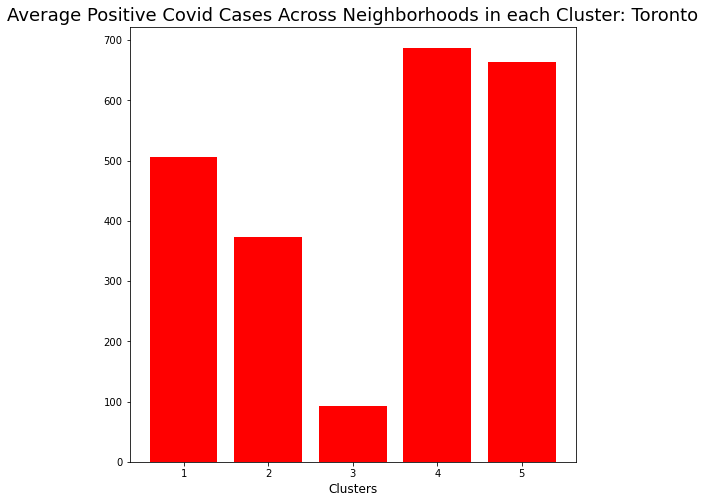

In [277]:
# get the number of neighborhoods and covid cases for each cluster
TCC=Toronto_clustered.groupby(['Cluster Labels'], as_index=False).agg({'Neighborhood':'count','Case Count':'sum'})
# calculate avregare cases per neighborhood in each cluster
TCC['Case Per Neighbohood']=(TCC['Case Count']/TCC['Neighborhood']).round(2)
# adjust the cluster labels
TCC['Cluster Labels']=TCC['Cluster Labels']+1
print(TCC)

# generate plot
plt.figure(figsize=(8,8))
plt.bar(TCC['Cluster Labels'],TCC['Case Per Neighbohood'], color='red')
plt.xlabel('Clusters', fontsize='12')
plt.title('Average Positive Covid Cases Across Neighborhoods in each Cluster: Toronto', fontsize='18')
plt.show()

### NYC Clusters

**Cluster 1**

In [261]:
NYC_clustered.loc[NYC_clustered['Cluster Labels'] == 0, NYC_clustered.columns[[0]+[1]+[4]+ list(range(6, NYC_clustered.shape[1]))]]

Borough         Neighborhood  Case Count 1st Most Common Venue  \
1            Bronx           Co-op City      1197.0           Bus Station   
2            Bronx            Fieldston       416.0                 River   
3            Bronx            Riverdale      1314.0                  Park   
15           Bronx           West Farms       774.0           Bus Station   
20           Bronx           Morrisania      2180.0        Discount Store   
21           Bronx            Soundview      4709.0    Chinese Restaurant   
34           Bronx       Pelham Gardens      1081.0              Pharmacy   
35           Bronx            Concourse      3599.0         Deli / Bodega   
36           Bronx             Edenwald      3047.0           Supermarket   
57        Brooklyn        East New York      5322.0            Food Truck   
59        Brooklyn            Flatlands      2801.0              Pharmacy   
121         Queens        Fresh Meadows       789.0           Bus Station   
126         Queens        South Jamaica      1295.0                Bakery   
127         Queens           St. Albans      2727.0  Caribbean Restaurant   
128         Queens  Springfield Gardens       806.0            Donut Shop   
129         Queens      Cambria Heights       980.0            Restaurant   
130         Queens             Rosedale      2552.0     Accessories Store   
138         Queens           Holliswood      1331.0   Fried Chicken Joint   
139         Queens      Jamaica Estates      1100.0          Intersection   
160  Staten Island         Graniteville       570.0            Food Truck   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
1                    Park            Restaurant         Grocery Store   
2                   Plaza           Bus Station           Yoga Studio   
3             Bus Station                  Bank                 Plaza   
15               Bus Stop                  Park        Ice Cream Shop   
20            Bus Station            Donut Shop         Grocery Store   
21           Burger Joint           Bus Station              Pharmacy   
34            Bus Station           Pizza Place            Print Shop   
35    Fried Chicken Joint         Grocery Store           Bus Station   
36          Grocery Store           Bus Station           Yoga Studio   
57                  Plaza         Event Service  Caribbean Restaurant   
59    Fried Chicken Joint  Fast Food Restaurant  Caribbean Restaurant   
121              Pharmacy    Chinese Restaurant            Food Truck   
126              Bus Line        Shop & Service         Grocery Store   
127         Deli / Bodega    Chinese Restaurant       Motorcycle Shop   
128           Bus Station   Fried Chicken Joint  Fast Food Restaurant   
129          Liquor Store  Gym / Fitness Center             Nightclub   
130         Jewelry Store              Pharmacy    Chinese Restaurant   
138         Grocery Store     Convenience Store              Bus Line   
139     Indian Restaurant           Bus Station               Dog Run   
160         Boat or Ferry         Grocery Store           Yoga Studio   

             5th Most Common Venue  6th Most Common Venue  \
1                       Bagel Shop               Pharmacy   
2              Filipino Restaurant     English Restaurant   
3                              Gym   Medical Supply Store   
15                      Donut Shop               Bus Line   
20            Fast Food Restaurant            Pizza Place   
21                Basketball Court         Discount Store   
34              Spanish Restaurant     Chinese Restaurant   
35                     Supermarket  Check Cashing Service   
36               Fish & Chips Shop          Event Service   
57            Fast Food Restaurant           Home Service   
59                     Video Store              Nightclub   
121  Vegetarian / Vegan Restaurant             Playground   
126           Caribbean Restaurant            Bus Station   
127  

**Cluster 2**

In [268]:
NYC_clustered.loc[NYC_clustered['Cluster Labels'] == 1, NYC_clustered.columns[[0]+[1]+[4]+ list(range(6, NYC_clustered.shape[1]))]]

Borough               Neighborhood  Case Count  \
4            Bronx                Kingsbridge      3859.0   
5        Manhattan                Marble Hill       898.0   
8            Bronx             Williamsbridge      2512.0   
9            Bronx                 Baychester      1081.0   
10           Bronx             Pelham Parkway      2438.0   
11           Bronx                City Island       244.0   
12           Bronx         University Heights      3136.0   
14           Bronx                    Fordham      1611.0   
16           Bronx                    Melrose      1348.0   
17           Bronx                 Mott Haven      3332.0   
18           Bronx                Port Morris      1031.0   
19           Bronx                Hunts Point      1919.0   
22           Bronx               Clason Point      1183.0   
24           Bronx               Country Club      1360.0   
25           Bronx                Parkchester      1008.0   
26           Bronx         Westchester Square      2075.0   
29           Bronx                    Belmont      2326.0   
31           Bronx            North Riverdale       416.0   
32           Bronx                 Pelham Bay      1068.0   
37        Brooklyn                  Bay Ridge      1403.0   
38        Brooklyn                Bensonhurst      3426.0   
39        Brooklyn                Sunset Park      5522.0   
40        Brooklyn                 Greenpoint      1035.0   
41        Brooklyn                  Gravesend      3786.0   
42        Brooklyn             Brighton Beach      2311.0   
43        Brooklyn             Sheepshead Bay      2950.0   
45        Brooklyn                 Kensington      1696.0   
46        Brooklyn            Windsor Terrace      2195.0   
47        Brooklyn           Prospect Heights       772.0   
48        Brooklyn                   Bushwick      2400.0   
49        Brooklyn           Brooklyn Heights       482.0   
50        Brooklyn                Cobble Hill       310.0   
51        Brooklyn            Carroll Gardens       310.0   
52        Brooklyn                   Red Hook       310.0   
53        Brooklyn                    Gowanus       498.0   
54        Brooklyn                Fort Greene       478.0   
55        Brooklyn                 Park Slope      1091.0   
56        Brooklyn              Cypress Hills      4488.0   
58        Brooklyn                   Canarsie      4301.0   
60        Brooklyn            Manhattan Beach      1512.0   
61        Brooklyn               Coney Island       799.0   
62        Brooklyn                 Bath Beach      2274.0   
64        Brooklyn              Dyker Heights       972.0   
65        Brooklyn            Gerritsen Beach      1438.0   
67        Brooklyn               Clinton Hill      1250.0   
68        Brooklyn                Boerum Hill       593.0   
69        Brooklyn  Prospect Lefferts Gardens      2991.0   
70        Brooklyn               Bergen Beach      1076.0   
72        Brooklyn          East Williamsburg      2394.0   
73        Brooklyn              Fort Hamilton      1403.0   
74       Manhattan                  Chinatown      1715.0   
75       Manhattan                     Inwood       895.0   
76       Manhattan           Hamilton Heights      1280.0   
77       Manhattan                East Harlem      5347.0   
78       Manhattan            Upper East Side      2742.0   
79       Manhattan                  Yorkville      1324.0   
80       Manhattan                 Lenox Hill      1417.0   
81       Manhattan           Roosevelt Island       356.0   
82       Manhattan            Upper West Side      2344.0   
83       Manhattan             Lincoln Square      1544.0   
84       Manhattan                Murray Hill       768.0   
85       Manhattan                Murray Hill      2738.0   
86       Manhattan                    Chelsea      1575.0   
87       Manhattan          Greenwich Village       734.0   
88       Manhattan               East Village 

**Cluster 3**

In [267]:
NYC_clustered.loc[NYC_clustered['Cluster Labels'] == 2, NYC_clustered.columns[[0]+[1]+[4]+ list(range(6, NYC_clustered.shape[1]))]]

Borough Neighborhood  Case Count 1st Most Common Venue  \
151  Staten Island   Port Ivory       570.0                   Bar   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
151           Yoga Studio    Frozen Yogurt Shop  Ethiopian Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
151         Event Service           Event Space               Exhibit   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
151    Falafel Restaurant                  Farm         Farmers Market

**Cluster 4**

In [266]:
NYC_clustered.loc[NYC_clustered['Cluster Labels'] == 3, NYC_clustered.columns[[0]+[1]+[4]+ list(range(6, NYC_clustered.shape[1]))]]

Borough Neighborhood  Case Count 1st Most Common Venue  \
148  Staten Island    Todt Hill      1495.0                  Park   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
148                 Trail   Empanada Restaurant    English Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
148  Ethiopian Restaurant         Event Service           Event Space   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
148               Exhibit    Falafel Restaurant                   Farm

**Cluster 5**

In [264]:
NYC_clustered.loc[NYC_clustered['Cluster Labels'] == 4, NYC_clustered.columns[[0]+[1]+[4]+ list(range(6, NYC_clustered.shape[1]))]]

Borough       Neighborhood  Case Count 1st Most Common Venue  \
0            Bronx          Wakefield      2294.0              Pharmacy   
6            Bronx           Woodlawn       444.0           Pizza Place   
7            Bronx            Norwood      1431.0           Pizza Place   
13           Bronx     Morris Heights      1525.0              Pharmacy   
23           Bronx        Throgs Neck      1360.0         Deli / Bodega   
27           Bronx           Van Nest      1782.0           Pizza Place   
28           Bronx        Morris Park      1068.0           Pizza Place   
30           Bronx     Spuyten Duyvil       898.0                  Bank   
33           Bronx        Castle Hill      1183.0                Market   
44        Brooklyn           Flatbush      1949.0         Deli / Bodega   
63        Brooklyn       Borough Park      5284.0                  Bank   
66        Brooklyn        Marine Park      1076.0        Baseball Field   
71        Brooklyn            Midwood      7989.0           Pizza Place   
104         Queens      Richmond Hill      3470.0                Lounge   
111         Queens           Glendale      2304.0               Brewery   
113         Queens          Woodhaven      2349.0         Deli / Bodega   
115         Queens   South Ozone Park      4466.0         Deli / Bodega   
116         Queens      College Point      1143.0                Bakery   
117         Queens         Whitestone      1719.0       Bubble Tea Shop   
119         Queens          Bellerose      1862.0         Deli / Bodega   
120         Queens  Kew Gardens Hills      1040.0                  Bank   
122         Queens          Briarwood      1481.0         Deli / Bodega   
131         Queens       Far Rockaway      2196.0         Deli / Bodega   
132         Queens      Broad Channel       295.0         Deli / Bodega   
142         Queens         Lindenwood       519.0         Moving Target   
143         Queens          Laurelton       983.0  Caribbean Restaurant   
145         Queens       North Corona      3536.0         Deli / Bodega   
149  Staten Island      Port Richmond       546.0      Basketball Court   
150  Staten Island   Mariner's Harbor       570.0    Italian Restaurant   
164  Staten Island          Rossville      2030.0            Bagel Shop   
169  Staten Island           Elm Park      1345.0    Italian Restaurant   
172         Queens             Utopia       430.0         Deli / Bodega   
174          Bronx         Mount Hope      2501.0         Deli / Bodega   
178  Staten Island       Prince's Bay       761.0           Pizza Place   
180          Bronx           Allerton      2512.0         Deli / Bodega   

         2nd Most Common Venue      3rd Most Common Venue  \
0               Sandwich Place             Ice Cream Shop   
6            Food & Drink Shop                        Pub   
7                Deli / Bodega                       Bank   
13                        Bank              Grocery Store   
23            Asian Restaurant                Pizza Place   
27               Deli / Bodega                        Spa   
28               Deli / Bodega                     Bakery   
30                        Park            Thai Restaurant   
33                        Bank             Cosmetics Shop   
44                 Coffee Shop       Caribbean Restaurant   
63                 Pizza Place                   Pharmacy   
66          Athletics & Sports           Basketball Court   
71           Convenience Store                   Pharmacy   
104              Deli / Bodega  Latin American Restaurant   
111              Deli / Bodega                Pizza Place   
113                   Pharmacy                       Park   
115                       Park                        Bar   
116                Pizza Place              Deli / Bodega   
117               Dance Studio              Deli / Bodega   
119                Pizza Place         Chinese Restaurant   
120                Pizza Plac

**Number of Covid cases in each Cluster**

   Cluster Labels  Neighborhood  Case Count  Case Per Neighbohood
0               1            20     38590.0               1929.50
1               2           124    208909.0               1684.75
2               3             1       570.0                570.00
3               4             1      1495.0               1495.00
4               5            35     66341.0               1895.46


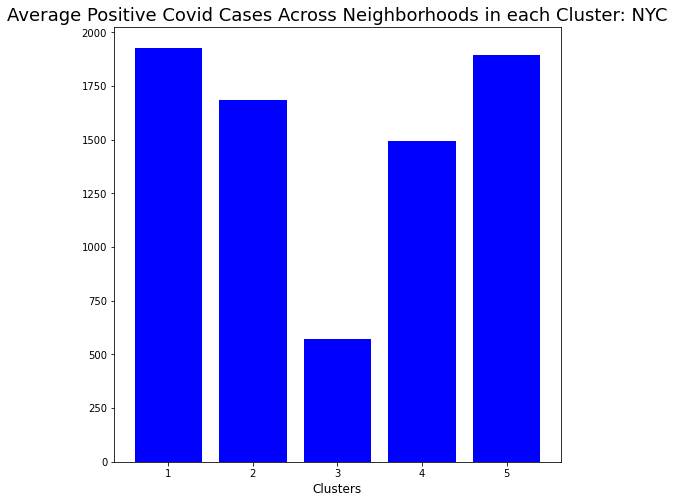

In [278]:
# get the number of neighborhoods and covid cases for each cluster
NYCC=NYC_clustered.groupby(['Cluster Labels'], as_index=False).agg({'Neighborhood':'count','Case Count':'sum'})
# calculate avregare cases per neighborhood in each cluster
NYCC['Case Per Neighbohood']=(NYCC['Case Count']/NYCC['Neighborhood']).round(2)
# adjust the cluster labels
NYCC['Cluster Labels']=NYCC['Cluster Labels']+1
print(NYCC)

# generate plot
plt.figure(figsize=(8,8))
plt.bar(NYCC['Cluster Labels'],NYCC['Case Per Neighbohood'], color='blue')
plt.xlabel('Clusters', fontsize='12')
plt.title('Average Positive Covid Cases Across Neighborhoods in each Cluster: NYC', fontsize='18')
plt.show()